# This notebook demonstrates the results of the updated 825nm SPC mode for the Roman Space Telescope. 

In [4]:
from astropy.io import fits
import astropy.units as u
import webbpsf
from webbpsf import wfirst
import ipywidgets
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})
import os
from pathlib import Path
import numpy as np

webbpsf.setup_logging()
webbpsfdir = Path('/groups/douglase/webbpsf-data/CGI/optics') # insert your own path to the CGI optics directory
f825dir = webbpsfdir/'F825'

def display_both(psf):
    for inter in psf[1]:
        plt.figure()
        inter.display(what='both')
        
from importlib import reload

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


## The updated mode now uses Phase-B data files which must be updated in order for the correct pixel scales to be used in the process. The files that are altered here are the shaped pupil file, the focal plane mask file, and the lyot stop file.

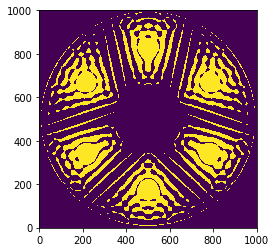

In [5]:
# First is the shapedpupil file
f825spm_fname = f825dir/'SPM_SPC-20181220_1000_rounded9_gray_rotated.fits'
f825spm = fits.open(f825spm_fname, mode='update')

f825spm_data = f825spm[0].data

f825spm[0].header['PUPLDIAM'] = 2.3631
f825spm[0].header['PUPLSCAL'] = 2.3631/1000

f825spm.close()

plt.imshow(f825spm_data)

0.001440213830594173 arcsec 0.020000000000000004


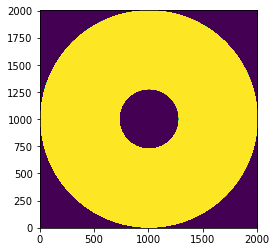

In [6]:
# Next is the FPM file for which the pixel scale must be calculated first based on lambda/D information
lamc = 825e-9*u.m
D = 2.3631*u.m
lamD825 = lamc/D
as_per_lamD = lamc * 360.0 * 3600.0 / (2 * np.pi * D)    # as per lambda0/D

f825fpm_pxscl = (lamD825/50*u.radian).to(u.arcsecond)
print(f825fpm_pxscl, f825fpm_pxscl.value/as_per_lamD)

f825fpm_fname = f825dir/'FPM_res50_SPC-20181220.fits'
f825fpm = fits.open(f825fpm_fname, mode='update')

f825fpm_data = f825fpm[0].data
f825fpm[0].header['PIXSCALE'] = f825fpm_pxscl.value

f825fpm.close()

plt.imshow(f825fpm_data)

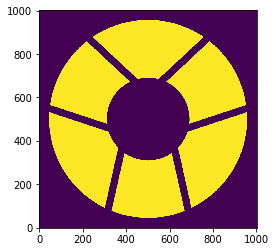

In [7]:
# Last is the lyot stop file
f825ls_fname = f825dir/'LS_SPC-20181220_1k_rotated.fits'
f825ls = fits.open(f825ls_fname, mode='update')

f825ls_data = f825ls[0].data

f825ls[0].header['PUPLDIAM'] = 2.3631
f825ls[0].header['PUPLSCAL'] = 2.3631/1000

f825ls.close()

plt.imshow(f825ls_data)

## Now the mode for the SPC 730 mode can be used. 

[webbpsf] Set the following optical configuration:
[webbpsf] camera = IMAGER, filter = F825, apodizer = DISKSPC825, fpm = DISKSPC_F825_ANNULUS, lyotstop = LS_F825
[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F825...
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_SPC-20181220.fits
[  poppy] 

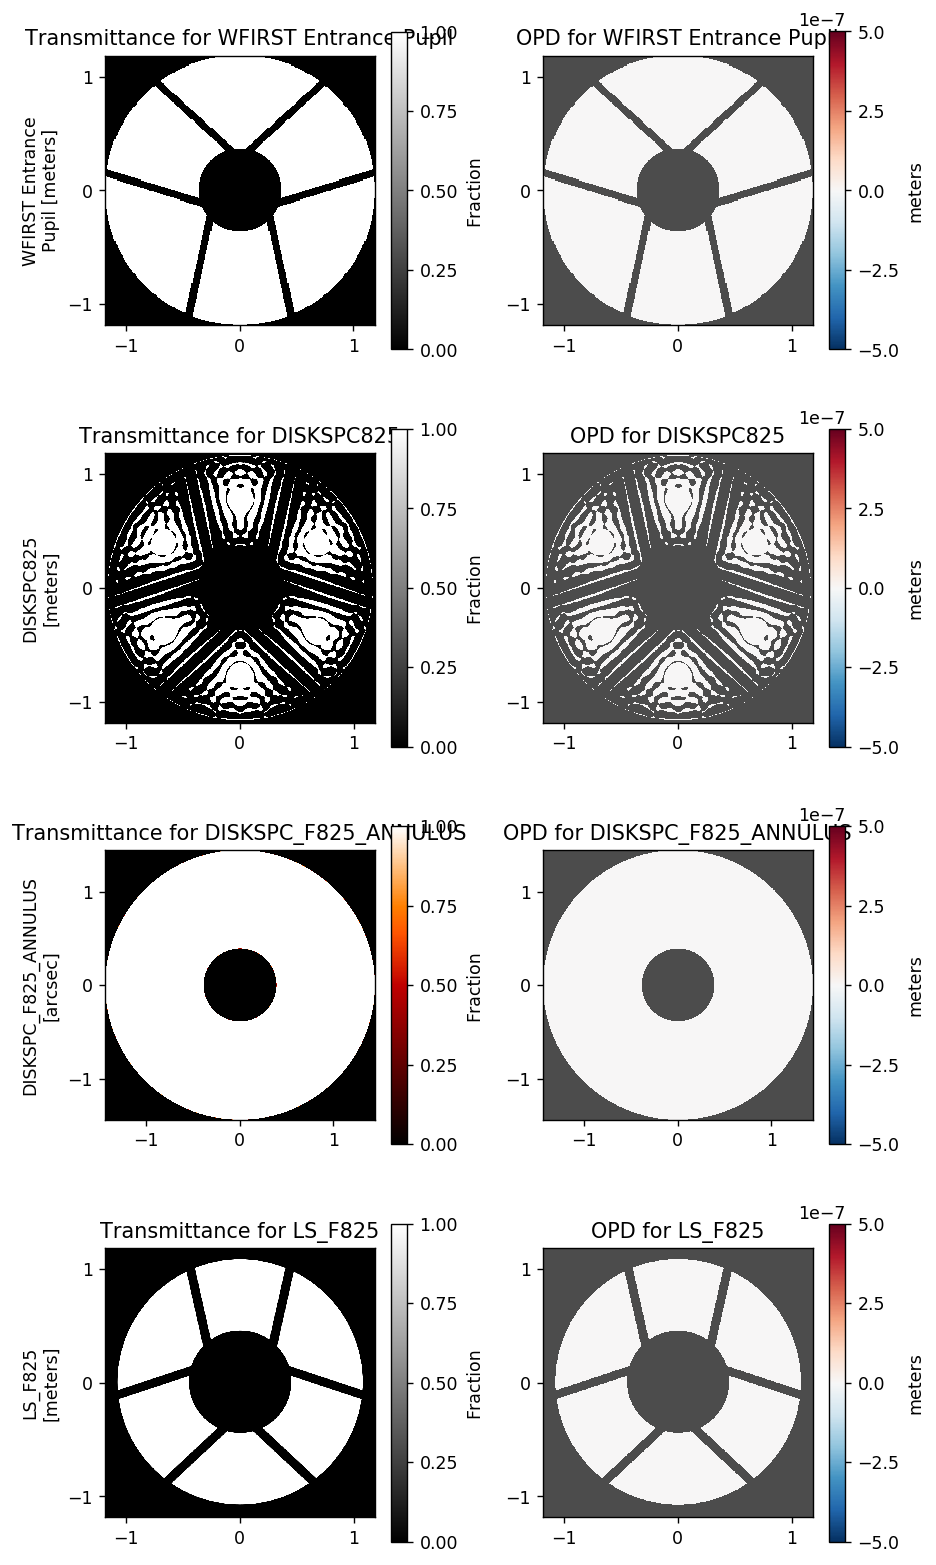

In [8]:
reload(wfirst)
spc825 = wfirst.CGI(mode='DISKSPC_F825')
plt.figure(figsize=(8,16), dpi=125)
spc825.display()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.25)

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_SPC-20181220.fits
[  poppy] Added image plane: DISKSPC_F825_ANNULUS
[  poppy] LS_F825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/LS_SPC-2018

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 1.893 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 4


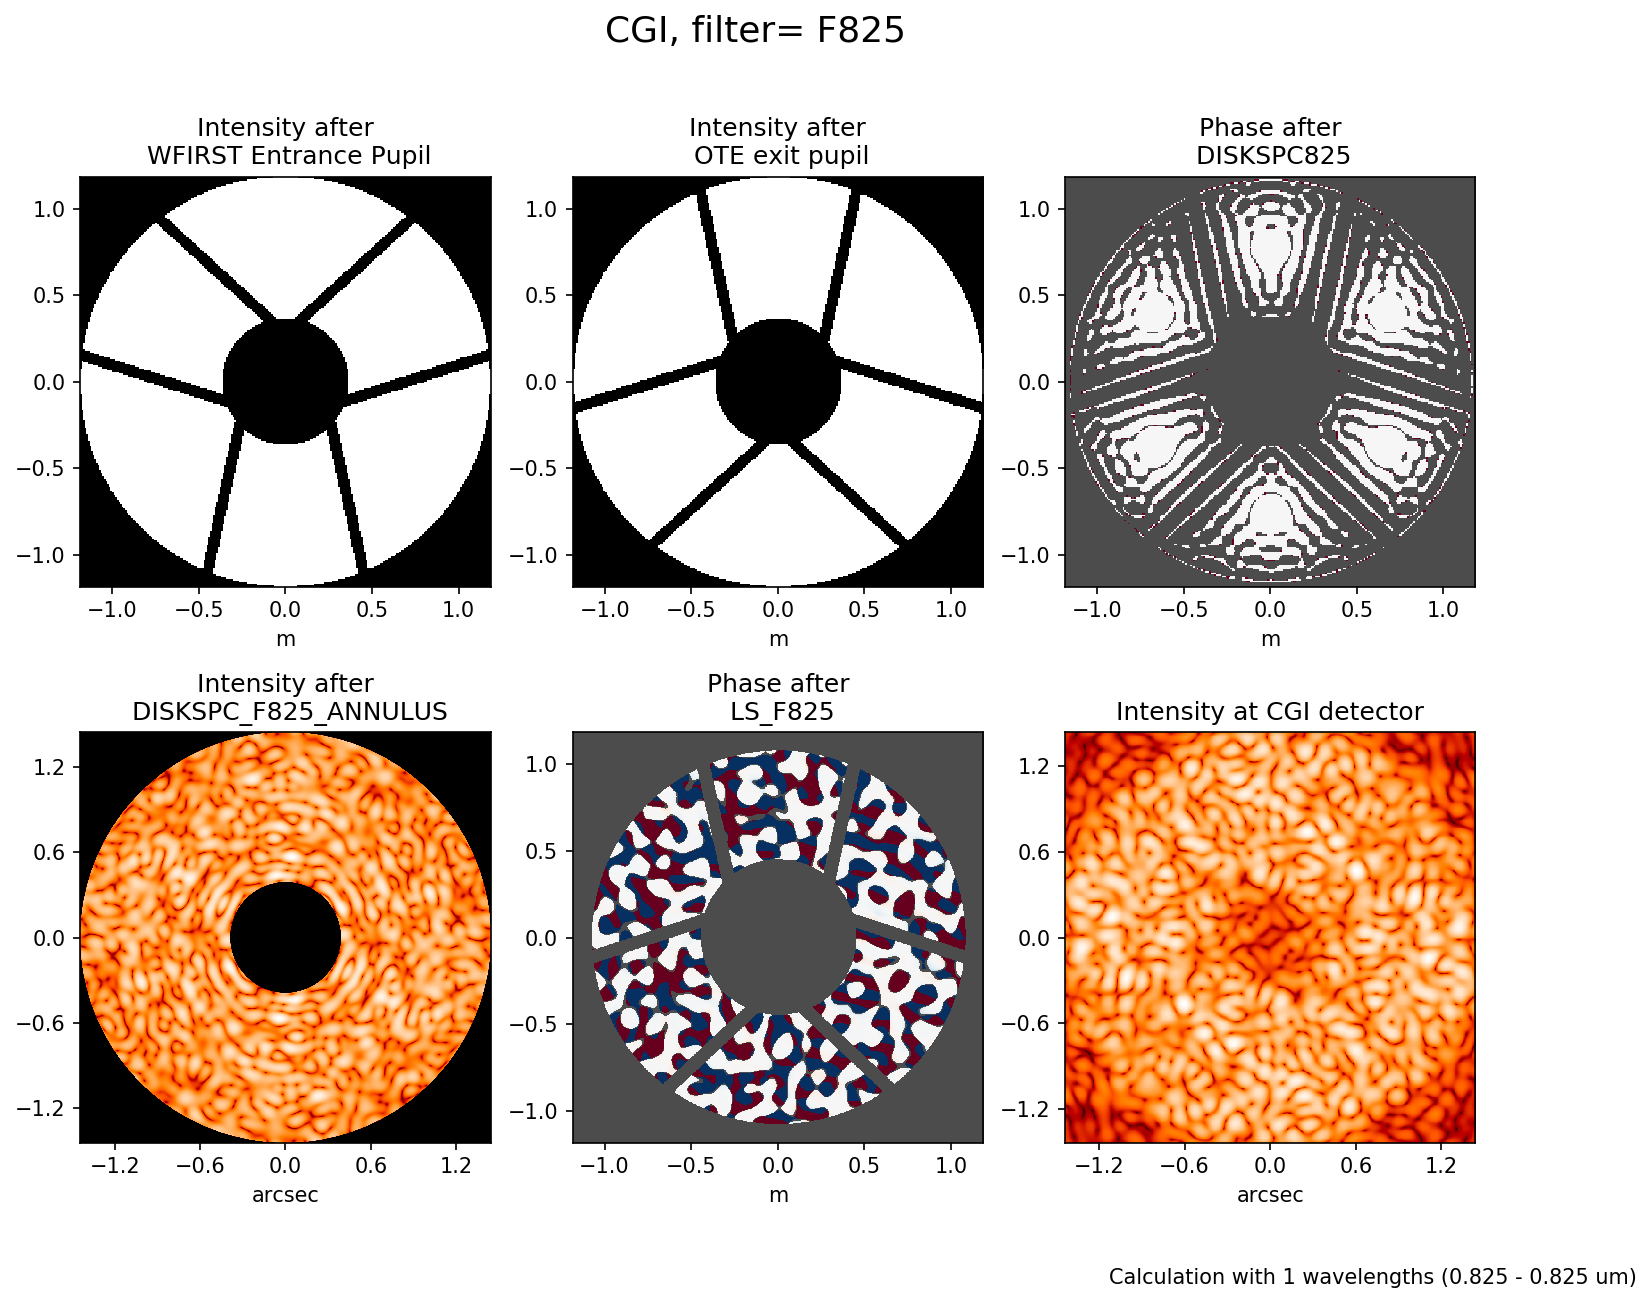

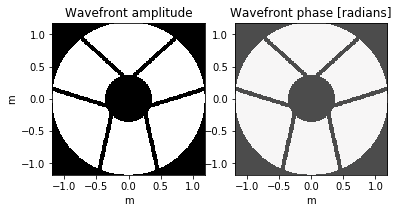

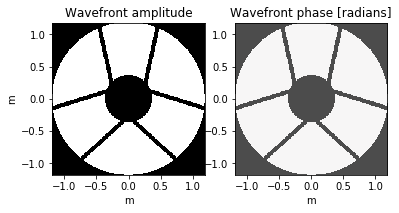

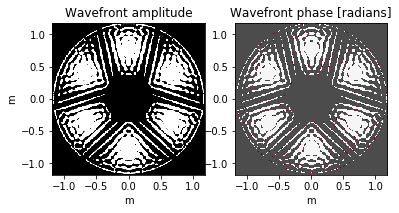

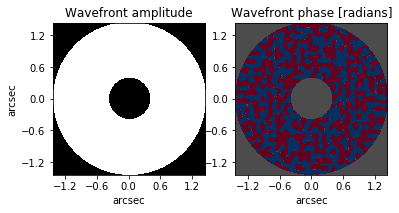

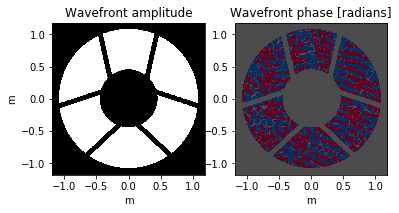

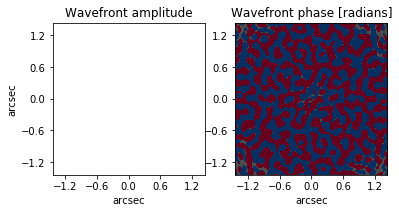

In [9]:
fov_as = 40*as_per_lamD.value
spc825.options['source_offset_r'] = 0 # arcsec
spc825.options['source_offset_theta'] = 0. # deg w.r.t. North

plt.figure(figsize=[12,9], dpi=150)
monopsf_onax = spc825.calc_psf(nlambda=1, fov_arcsec=fov_as, display=True, return_intermediates=True)

display_both(monopsf_onax)

## Calculate off-axis PSF.

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_SPC-20181220.fits
[  poppy] Added image plane: DISKSPC_F825_ANNULUS
[  poppy] LS_F825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/LS_SPC-2018

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 1.873 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 4


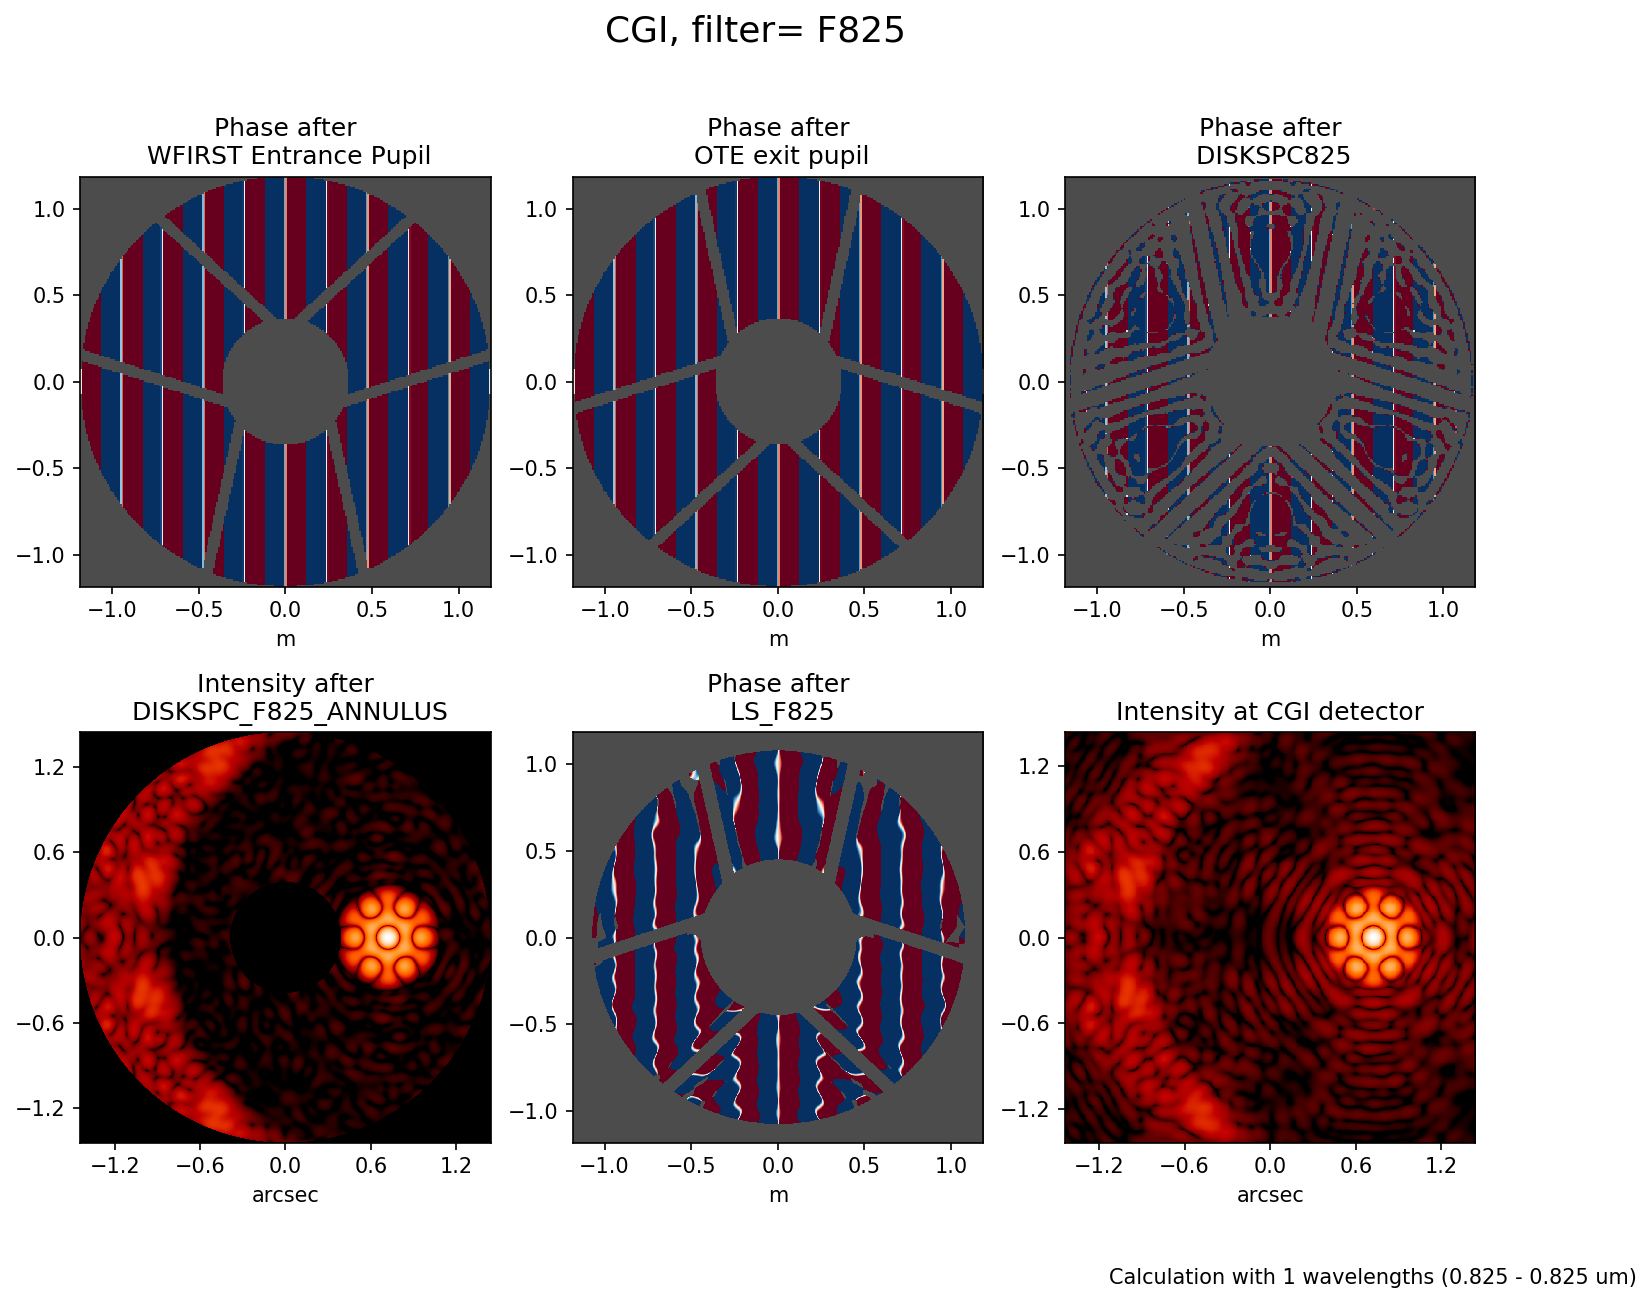

In [13]:
spc825.options['source_offset_r'] = 10*as_per_lamD.value # arcsec
spc825.options['source_offset_theta'] = -90. # deg w.r.t. North

plt.figure(figsize=[12,9], dpi = 150)
monopsf_offax = spc825.calc_psf(nlambda=1, fov_arcsec=fov_as, display=True, return_intermediates=True)

## Display both PSFs side-by-side.

The pixelscale of the images generated are 0.086957 lam/D


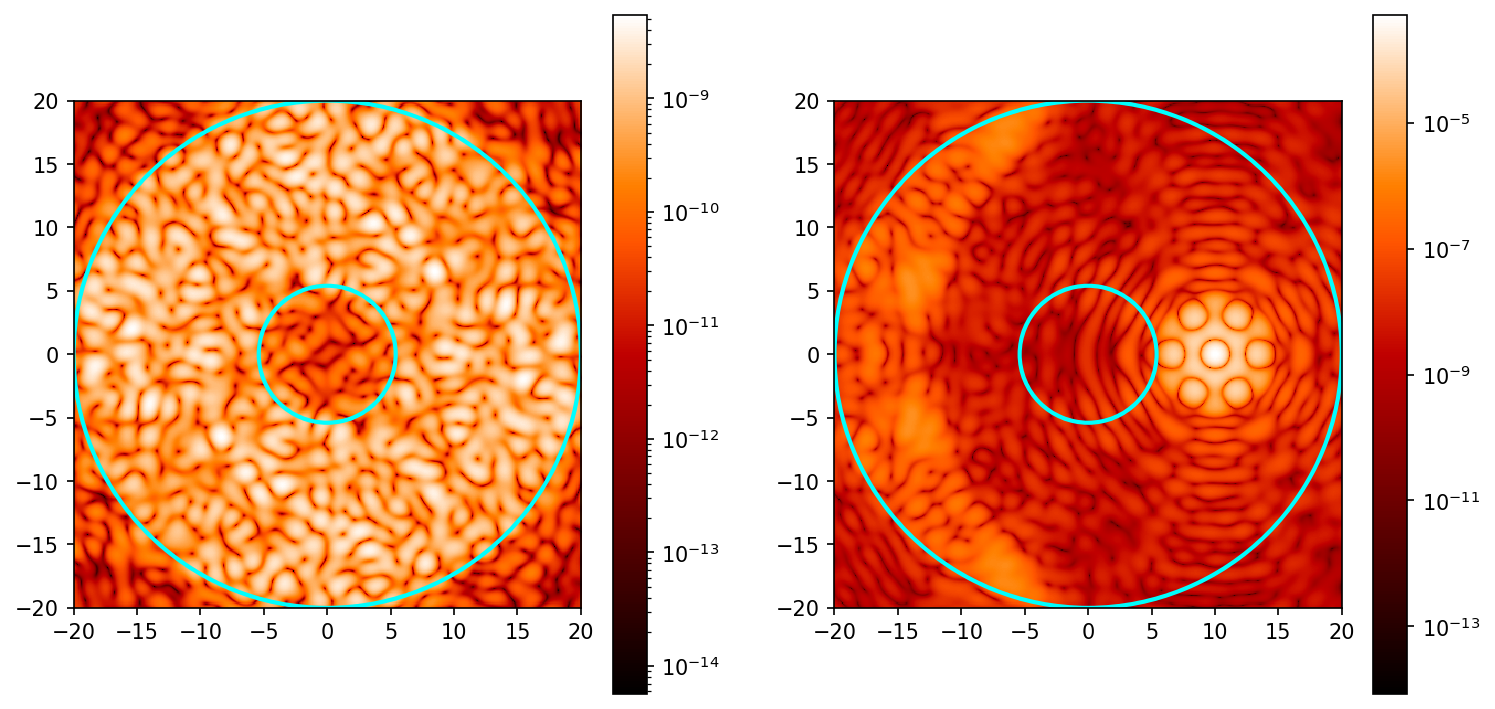

In [28]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=150)

exmax = fov_as/as_per_lamD.value/2
pxscl_lamD = exmax/(monopsf_offax[0][0].data.shape[0]/2) # assuming the same pixelscale for both images
extent = [-exmax,exmax,-exmax,exmax]
print('The pixelscale of the images generated are {:.5} lam/D'.format(pxscl_lamD))

im = ax[0].imshow(monopsf_onax[0][0].data, norm=LogNorm(), cmap=plt.get_cmap('gist_heat'), extent=extent)
ax[0].add_patch(Circle((0,0),5.4,edgecolor='cyan', facecolor='none', linewidth=2))
ax[0].add_patch(Circle((0,0),20,edgecolor='cyan', facecolor='none', linewidth=2))
fig.colorbar(im, ax=ax[0], shrink=1) 

im = ax[1].imshow(monopsf_offax[0][0].data, norm=LogNorm(), cmap=plt.get_cmap('gist_heat'), extent=extent)
ax[1].add_patch(Circle((0,0),5.4,edgecolor='cyan', facecolor='none', linewidth=2))
ax[1].add_patch(Circle((0,0),20,edgecolor='cyan', facecolor='none', linewidth=2))
fig.colorbar(im, ax=ax[1], shrink=1) 

## Compare the off-axis PSF generated by the Webbpsf model to one that was created by the PROPER Phase-B model. 

The pixelscale of the result from PROPER is 0.086957 lam/D.


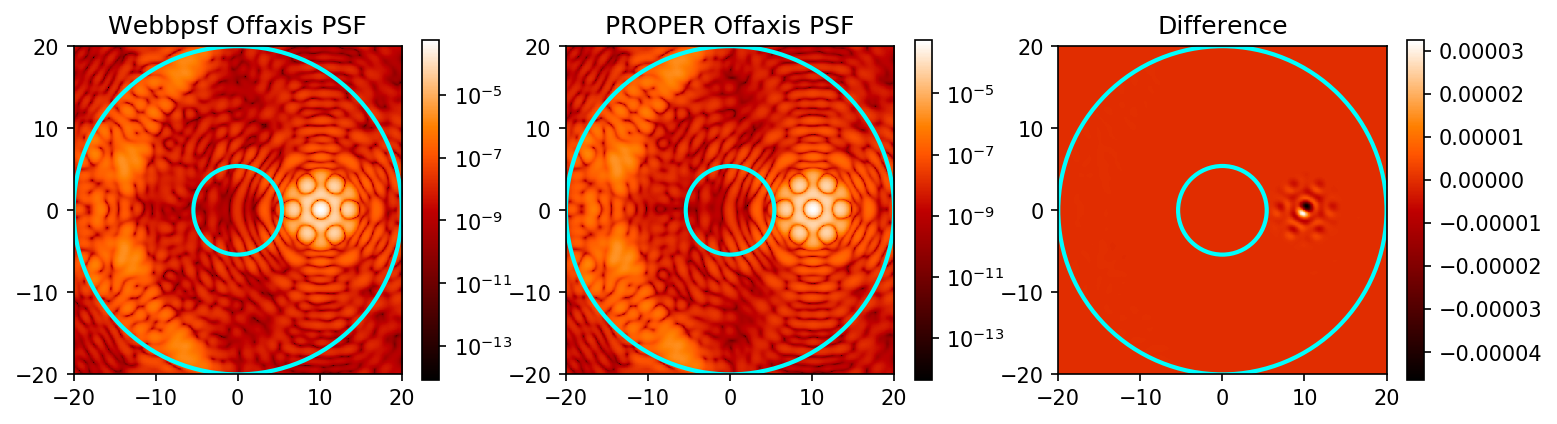

In [37]:
proper_spc825 = fits.getdata('proper_spcf825_result.fits')
proper_spc825_hdr = fits.getheader('proper_spcf825_result.fits')
print('The pixelscale of the result from PROPER is {:0.5} lam/D.'.format(proper_spc825_hdr['PIXSCALE']))

# trim the PROPER result to match the dimensions of the Webbpsf result
trim = int( (proper_spc825.shape[0] - monopsf_offax[0][0].data.shape[0])/2 )
proper_spc825 = proper_spc825[trim:-trim,trim:-trim]

fig, ax  = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=150)

exmax = fov_as/as_per_lamD.value/2
extent = [-exmax,exmax,-exmax,exmax]

im = ax[0].imshow(monopsf_offax[0][0].data, norm=LogNorm(), cmap=plt.get_cmap('gist_heat'), extent=extent)
ax[0].add_patch(Circle((0,0),5.4,edgecolor='cyan', facecolor='none', linewidth=2))
ax[0].add_patch(Circle((0,0),20,edgecolor='cyan', facecolor='none', linewidth=2))
ax[0].set_title('Webbpsf Offaxis PSF')
fig.colorbar(im, ax=ax[0], shrink=0.75) 

exmax = proper_spc825_hdr['PIXSCALE']*proper_spc825.shape[0]/2 # 0.1lam/D is the pixelscale for the proper result
extent = [-exmax,exmax,-exmax,exmax]

im = ax[1].imshow(proper_spc825, norm=LogNorm(), cmap=plt.get_cmap('gist_heat'), extent=extent)
ax[1].add_patch(Circle((0,0),5.4,edgecolor='cyan', facecolor='none', linewidth=2))
ax[1].add_patch(Circle((0,0),20,edgecolor='cyan', facecolor='none', linewidth=2))
ax[1].set_title('PROPER Offaxis PSF')
fig.colorbar(im, ax=ax[1], shrink=0.75) 

diff = monopsf_offax[0][0].data - proper_spc825
im = ax[2].imshow(diff, cmap=plt.get_cmap('gist_heat'), extent=extent)
ax[2].add_patch(Circle((0,0),5.4,edgecolor='cyan', facecolor='none', linewidth=2))
ax[2].add_patch(Circle((0,0),20,edgecolor='cyan', facecolor='none', linewidth=2))
ax[2].set_title('Difference')
fig.colorbar(im, ax=ax[2], shrink=0.75) 

## Calculate the contrast.

In [18]:
spc825 = spc825 = wfirst.CGI(mode='DISKSPC_F825')

filter_fname = spc825._filters[spc825.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/70. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))//2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*spc825.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan//2]*1e9))
filter_hdulist.close()

[webbpsf] Set the following optical configuration:
[webbpsf] camera = IMAGER, filter = F825, apodizer = DISKSPC825, fpm = DISKSPC_F825_ANNULUS, lyotstop = LS_F825
System diffraction resolution element scale (lambda_0/D) in arcsec: 0.071
IFS spectral parameters: 7 channels of characteristic spectral width 11.79 nm,
ranging from 783 nm to 866 nm, centered on 825 nm


### Calculate an on-axis datacube of PSFs for different wavelengths.

In [19]:
spc825.options['source_offset_r'] = 0 # arcsec
spc825.options['source_offset_theta'] = 0 # deg w.r.t. North

spc_psf_onax = spc825.calc_datacube(wavelens, fov_arcsec=fov_as, oversample=8, display=False)
print("The resulting data cube has dimensions {} wavelengths x {} pixels x {} pixels".format\
      (spc_psf_onax[1].data.shape[0], spc_psf_onax[1].data.shape[1], spc_psf_onax[1].data.shape[2]))

[  poppy] Starting multiwavelength data cube calculation.
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_SPC-20181220.fits
[  poppy] Added image plane: DISKSPC_F825_ANNULUS
[  poppy] LS_F825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CG

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.571 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.463 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.559 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.500 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.444 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.577 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.491 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
The resulting data cube has dimensions 7 wavelengths x 115 pixels x 115 pixels


### Calculate an off-axis datacube of PSFs for different wavelengths.

In [20]:
spc825.options['source_offset_r'] = 10*lamoD_asec # source of 10lam/D used to normalize on-axis PSFs
spc825.options['source_offset_theta'] = -90. # deg w.r.t. North

spc_psf_offax = spc825.calc_datacube(wavelens, fov_arcsec=fov_as, oversample=8, display=False)
offax_peak_vec = np.max(np.max(spc_psf_offax[1].data, axis=-1), axis=-1)
offax_peak_cube = np.tile(offax_peak_vec[:,np.newaxis,np.newaxis],
                          (1, spc_psf_onax[1].data.shape[-2], spc_psf_onax[1].data.shape[-1]))

[  poppy] Starting multiwavelength data cube calculation.
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_SPC-20181220.fits
[  poppy] Added image plane: DISKSPC_F825_ANNULUS
[  poppy] LS_F825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CG

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.506 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.448 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.655 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.571 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.603 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.453 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 2.880428, oversample = 8, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /groups/douglase/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] DISKSPC825: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/SPM_SPC-20181220_1000_rounded9_gray_rotated.fits
[  poppy] Added pupil plane: DISKSPC825
[  poppy] DISKSPC_F825_ANNULUS: Loaded amplitude transmission from /groups/douglase/webbpsf-data/CGI/optics/F825/FPM_res50_

[  poppy] After resampling, optic phasor shape (256, 256) is smaller than input wavefront (256, 256); will zero-pad the rescaled array.


[  poppy]   Calculation completed in 0.433 s
[  poppy] PSF Calculation completed.
[  poppy]  Adding extension with image downsampled to detector pixel scale.
[  poppy]  Downsampling to detector pixel scale, by 8


### Display the off-axis PSFs.

In [21]:
def plt_psf_offax(wchan):
    plt.imshow(spc_psf_offax[1].data[wchan-1], norm=LogNorm(), cmap='gist_heat');
    plt.colorbar()
ipywidgets.interact(plt_psf_offax, wchan=(1,len(wavelens)));

interactive(children=(IntSlider(value=4, description='wchan', max=7, min=1), Output()), _dom_classes=('widget-…

### Display the on-axis PSFs normalized to be in contrast units.

In [22]:
spc_psf_onax_contrast = spc_psf_onax[1].data / offax_peak_cube

def plt_psf_onax(wchan):
    plt.imshow(spc_psf_onax_contrast[wchan-1], norm=LogNorm(),
               vmin=3e-10, vmax=1e-4, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_psf_onax, wchan=(1,Nchan));

interactive(children=(IntSlider(value=4, description='wchan', max=7, min=1), Output()), _dom_classes=('widget-…